# ESN
## Bonus-track Assignment 1: Mackey-Glass 17 task

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import mean_squared_error

Load the datset

In [14]:
#load the data
data = np.loadtxt("MG17.csv", delimiter=",")

#organize input and target 
x = data[:-1]
y = data[1:]
print(data)

[ 0.032164  0.040426  0.057861 ... -0.19556  -0.1368   -0.082192]


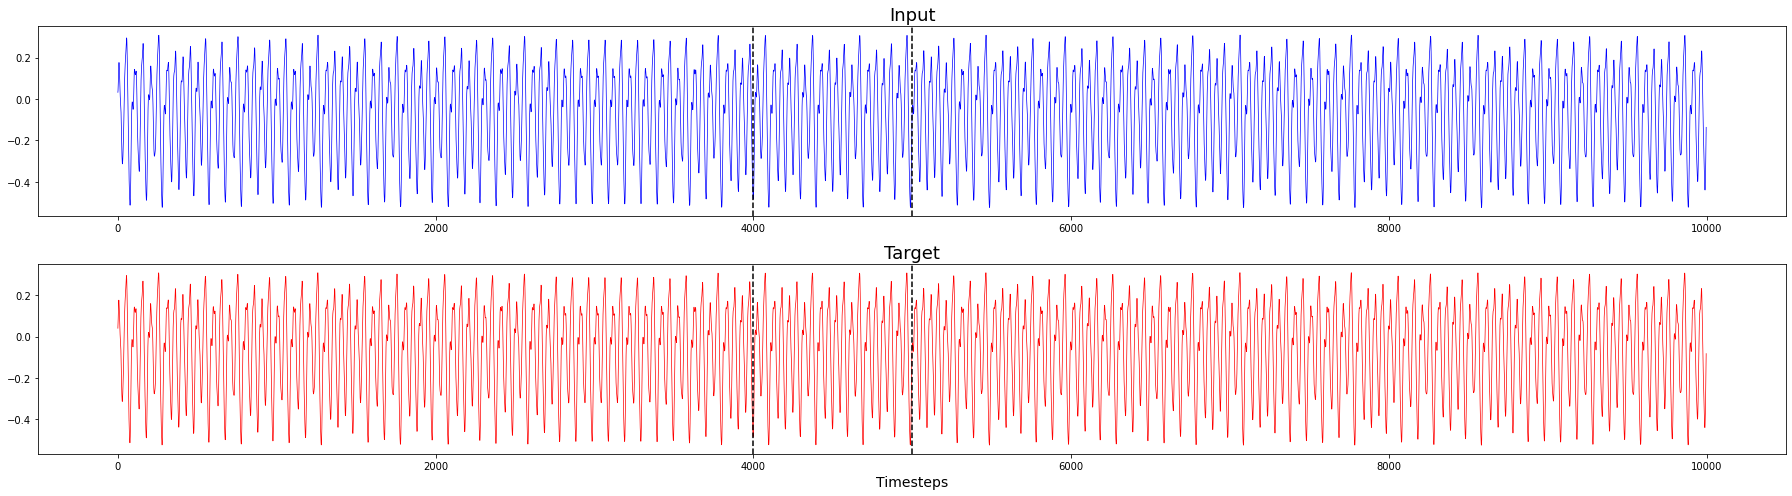

In [15]:
#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] 
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(x, color = 'b', linewidth= 0.7)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(y, color = 'r', linewidth = 0.7)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

---
## [loading variables]

In [16]:
'''
#to load esn variables

Wx = np.load('Wx.npy')
Wh = np.load('Wh.npy')
Wo = np.load('Wo.npy')
b  = np.load('b.npy')


#to load best hyperparameters

best_hp = np.load('best_hyperparams.npy')


#to load errors

errors = np.load('errors.npy')
'''

"\n#to load esn variables\n\nWx = np.load('Wx.npy')\nWh = np.load('Wh.npy')\nWo = np.load('Wo.npy')\nb  = np.load('b.npy')\n\n\n#to load best hyperparameters\n\nbest_hp = np.load('best_hyperparams.npy')\n\n\n#to load errors\n\nerrors = np.load('errors.npy')\n"

---

## Implement the ESN

We consider as hyperparameters of the model:
- number of reservoir neurons      [50,100]
- spectral radius      [0.5,0.9,0.99,1.2]
- input scaling    [0.01,0.1,1]
- bias scaling     [0.01,0.1,1]
- readout regularization (tickhonov regularization coefficient)    [0.01,0.1,1]
- sparsity of Wh       [0.1,0.5]

In [17]:
def esn (hyperparams, ntrials=1, plot=False, steps_to_plot=200, test=False, save = False):
    #unpack array of hyperparameters:
    Nh = int(hyperparams[0])
    rho = hyperparams[1]
    omega_x = hyperparams[2]
    omega_b = hyperparams[3]
    l = hyperparams[4]
    dh = hyperparams[5]

    Nx = 1 #input is 1-dimentional

    # For each hyper-parameterization, the performance
    # should be averaged over a number (ntrials) of reservoir guesses
    
    train_mse_hist = [] #to keep track of validation mse on different random instances of the ESN
    valid_mse_hist = [] #to keep track of validation mse on different random instances of the ESN
    test_mse_hist = [] #to keep track of validation mse on different random instances of the ESN

    for i in range (ntrials):

        # Initialize weights Wx and Wh
        Wx = np.random.rand(Nh, Nx)
        Wx = 2 * Wx - 1
        Wx = omega_x * Wx

        Wh = sparse.rand(Nh, Nh, density=dh)
        Wh.data = 2 * Wh.data - 1
        Wh = Wh.toarray()
        Wh = rho * (Wh / np.max(np.abs(np.linalg.eig(Wh)[0])))

        # Bias
        
        b = np.ones((Nh, Nx))
        b = omega_b * b
        

        #Run the reservoir on the input stream

        # Initialize state vector and hidden state history
        state = np.zeros((Nh, 1))
        H = state.copy()

        for t in range(len(x_train)):
            state = np.tanh(Wh.dot(state) + Wx.dot(x_train[t]) + b)
            H = np.hstack((H, state))


        #discard the washout
        washout_size = 100 #va bene tenerlo costante
        H = H[:, (washout_size+1):]
        Y = y_train[washout_size:]

        #train the readout using ridge regression
        Wo = np.dot(np.dot(Y,H.T),np.linalg.inv(np.dot(H,H.T)+l*np.identity(len(np.dot(H,H.T)))))

        #save the esn variables
        if save == True:
            np.save('Wx',Wx)
            np.save('Wh',Wh)
            np.save('Wo',Wo)
            np.save('b',b)

        #compute output

        o_tr = np.dot(Wo, H)
        err_tr = mean_squared_error(Y, o_tr)
        train_mse_hist.append(err_tr)
        if plot == True and i==1: #make the plot only of the first trial 
            plt.figure(figsize = (25,7))
            plt.subplot(211)
            plt.title(f'TRAINING - MSE = {err_tr}')
            plt.plot(o_tr, color = 'r', linewidth = 0.3, label='Output')
            plt.plot(Y, color = 'black', linewidth = 0.3, label='Target')
            plt.legend()
            plt.subplot(212)
            plt.title(f'First {steps_to_plot} steps')
            plt.plot(o_tr[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
            plt.plot(Y[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
            plt.legend()
            plt.savefig('training.pdf')

        #validation 

        H = state

        for t in range(len(x_valid)):
            state = np.tanh(Wh.dot(state) + Wx.dot(x_valid[t]) + b)
            H = np.hstack((H, state))

        H = H[:, 1:]

        o_valid = np.dot(Wo, H)
        err_valid = mean_squared_error(y_valid, o_valid)
        valid_mse_hist.append(err_valid)

        if plot == True and i==1: #make the plot only of the first trial
            plt.figure(figsize = (25,7))
            plt.subplot(211)
            plt.title(f'VALIDATION - MSE = {err_valid}')
            plt.plot(o_valid, color = 'r', linewidth = 0.3, label='Output')
            plt.plot(y_valid, color = 'black', linewidth = 0.3, label='Target')
            plt.legend()
            plt.subplot(212)
            plt.title(f'First {steps_to_plot} steps')
            plt.plot(o_valid[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
            plt.plot(y_valid[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
            plt.legend()
            plt.savefig('validation.pdf')
        


        #test

        if test == True:
            H = state

            for t in range(len(x_test)):
                state = np.tanh(Wh.dot(state) + Wx.dot(x_test[t]) + b)
                H = np.hstack((H, state))

            H = H[:, 1:]

            o_test = np.dot(Wo, H)
            err_test = mean_squared_error(y_test, o_test)
            test_mse_hist.append(err_test)

            if plot == True and i==1: #make the plot only of the first trial
                plt.figure(figsize = (25,7))
                plt.subplot(211)
                plt.title(f'TEST - MSE = {err_test}')
                plt.plot(o_test, color = 'r', linewidth = 0.3, label='Output')
                plt.plot(y_test, color = 'black', linewidth = 0.3, label='Target')
                plt.legend()
                plt.subplot(212)
                plt.title(f'First {steps_to_plot} steps')
                plt.plot(o_test[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
                plt.plot(y_test[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
                plt.legend()
                plt.savefig('test.pdf')
        
    avg_train_mse = np.mean(train_mse_hist)
    avg_val_mse = np.mean(valid_mse_hist)
    errors = [avg_train_mse, avg_val_mse]

    if test == True:
        avg_test_mse = np.mean(test_mse_hist)
        errors.append(avg_test_mse)
    if save == True:
        np.save('errors',errors)

    return avg_val_mse

## Model Selection
Focus on a limited search space due to temporal reasons

In [18]:
#hyperparameters
Nh = [50,100] #number of reservoir units
rho = [0.5,0.9,0.99,1.2] #spectral radius
omega_x = [0.01,0.1,1] #input scaling
omega_b = [0.01,0.1,1] #bias scaling
l = [0.01,0.1,1] #lambda tickhonov regularization coefficient
h_sparsity =  [0.1,0.5] #sparsity of Wh



#compute all the possible combinations
p = np.array(np.meshgrid(Nh, rho, omega_x, omega_b, l, h_sparsity)).T.reshape(-1,6)

print(f'The search space is composed of {len(p)} combinations of hyperparameters')
dim_search_space = len(p)

The search space is composed of 432 combinations of hyperparameters


In [19]:
best_hp = []
min_mae= 1e3 #initialize to a high value

for i in range(len(p)):
    hyperparameters = p[i,:]
    mae = esn(hyperparameters, ntrials=3)
    if mae < min_mae:
        min_mae = mae
        best_hp = hyperparameters
    print(f'iteration {i} of {dim_search_space}, mae = {mae},hyperparams = {hyperparameters}, best mae so far = {min_mae}')

print(f' BEST HYPERPARAMS{best_hp} corresponding to mae = {min_mae}')
#save the best hyperparameters found
np.save('best_hyperparams',best_hp)
np.save('min_mae',min_mae)

iteration 0 of 432, mae = 0.0009127569873686285,hyperparams = [5.e+01 5.e-01 1.e-02 1.e-02 1.e-02 1.e-01], best mae so far = 0.0009127569873686285
iteration 1 of 432, mae = 0.0005526057238901969,hyperparams = [5.e+01 9.e-01 1.e-02 1.e-02 1.e-02 1.e-01], best mae so far = 0.0005526057238901969
iteration 2 of 432, mae = 0.0005198614372494896,hyperparams = [5.0e+01 9.9e-01 1.0e-02 1.0e-02 1.0e-02 1.0e-01], best mae so far = 0.0005198614372494896
iteration 3 of 432, mae = 0.0010481416376046844,hyperparams = [5.0e+01 1.2e+00 1.0e-02 1.0e-02 1.0e-02 1.0e-01], best mae so far = 0.0005198614372494896
iteration 4 of 432, mae = 0.0006729238557770705,hyperparams = [1.e+02 5.e-01 1.e-02 1.e-02 1.e-02 1.e-01], best mae so far = 0.0005198614372494896
iteration 5 of 432, mae = 0.0003207642283094941,hyperparams = [1.e+02 9.e-01 1.e-02 1.e-02 1.e-02 1.e-01], best mae so far = 0.0003207642283094941
iteration 6 of 432, mae = 0.0003297101261195842,hyperparams = [1.0e+02 9.9e-01 1.0e-02 1.0e-02 1.0e-02 1.0

Train the model with the selected hyper-parametrization and make requested plots:

Best hyperparameters: [1.0e+02 9.9e-01 1.0e+00 1.0e-01 1.0e-02 5.0e-01]

Average errors over 5 trials: 
 Training MSE = 8.97708541688086e-07 
 Validation MSE = 9.332463700889118e-07 
 Test MSE = 8.991054990753914e-07


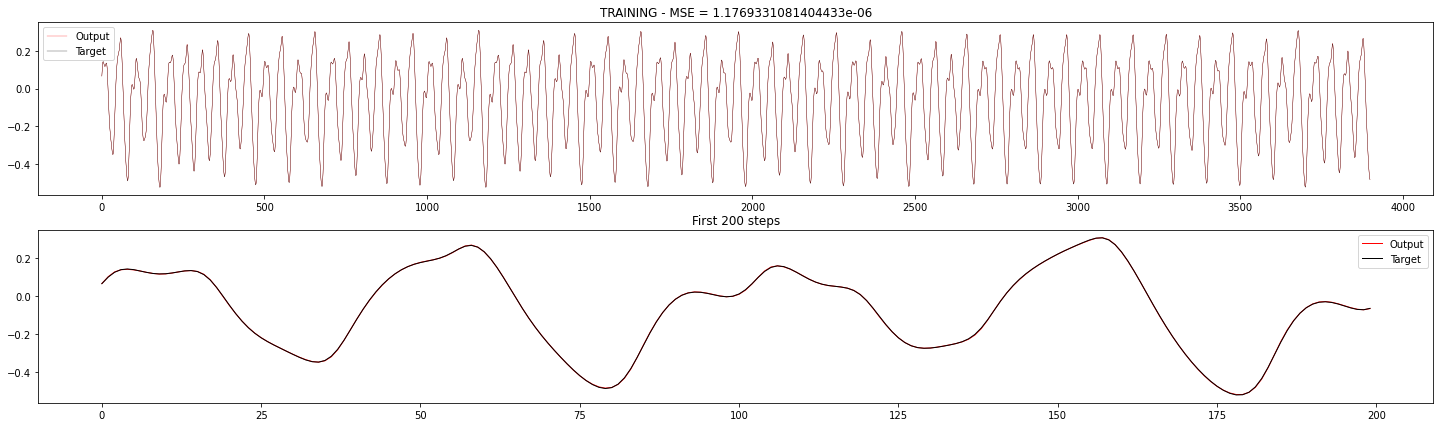

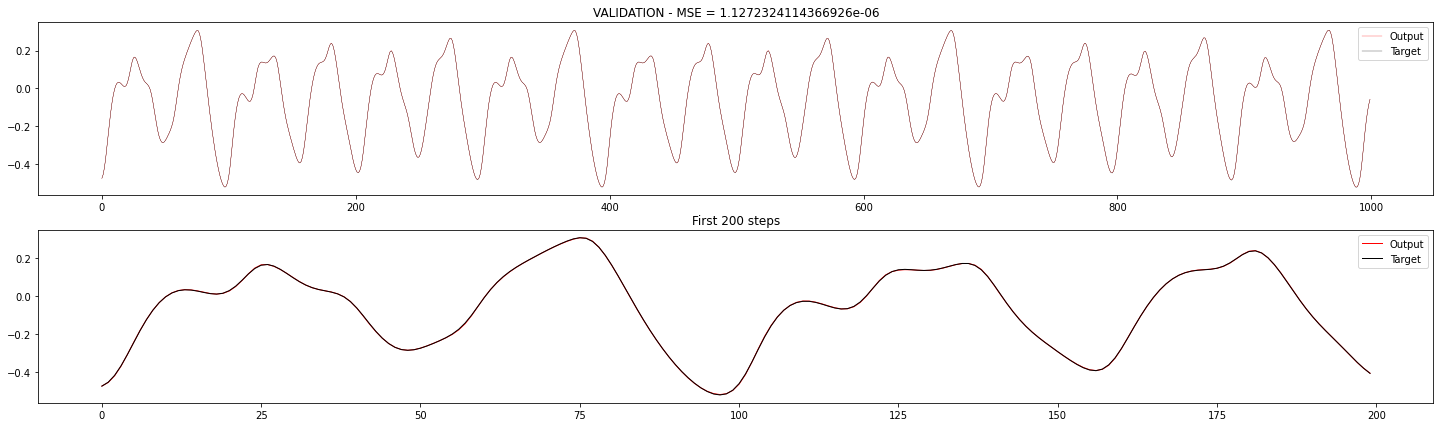

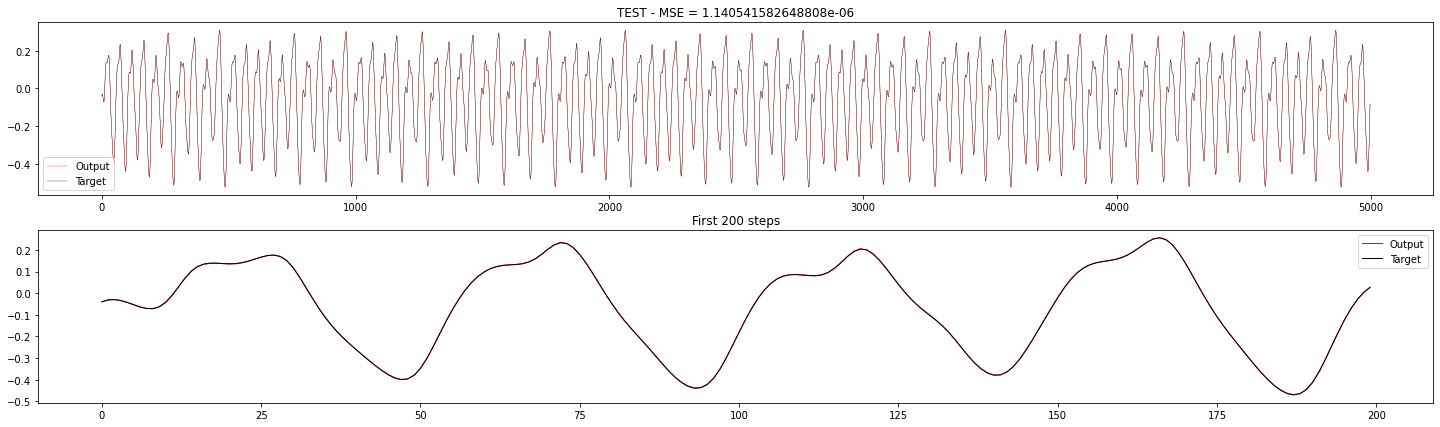

In [20]:
best_hp = np.load('best_hyperparams.npy')
print(f'Best hyperparameters: {best_hp}')

trials = 5
esn(best_hp,ntrials=trials,plot=True,test=True, save=True)

#to load errors:
errors = np.load('errors.npy')
print(f'\nAverage errors over {trials} trials: \n Training MSE = {errors[0]} \n Validation MSE = {errors[1]} \n Test MSE = {errors[2]}')